In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
dataframe = pd.read_csv('bitcoin_hourly.csv')
dataframe.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.614384e+12,2021-02-27 00:00:00,BTC/USDT,46276.88,46628.93,46156.24,46621.39,336.166565,1.558817e+07,8582.0
1,1.614380e+12,2021-02-26 23:00:00,BTC/USDT,45476.30,46444.57,45368.74,46276.87,2571.865785,1.185428e+08,60317.0
2,1.614377e+12,2021-02-26 22:00:00,BTC/USDT,45680.00,45988.77,45000.00,45476.30,4400.975291,2.005474e+08,123927.0
3,1.614373e+12,2021-02-26 21:00:00,BTC/USDT,46270.00,46867.00,45500.00,45677.46,3831.690182,1.771737e+08,85141.0
4,1.614370e+12,2021-02-26 20:00:00,BTC/USDT,46959.18,47115.38,46071.89,46270.00,3514.297867,1.637276e+08,80837.0


In [3]:
dataframe.describe()

,unix,open,high,low,close,Volume BTC,Volume USDT,tradecount
count,3.359600e+04,33596.000000,33596.000000,33596.000000,33596.000000,33596.000000,3.359600e+04,5012.000000
mean,2.408156e+11,10088.510021,10151.232791,10020.153279,10089.709901,1926.125372,2.384416e+07,60208.728851
std,5.713962e+11,7286.387181,7355.122064,7211.679373,7289.242215,2046.170713,4.335391e+07,42136.528257
min,1.502942e+09,2919.000000,2950.000000,2817.000000,2919.000000,0.000000,0.000000e+00,0.000000
25%,1.533192e+09,6529.972500,6550.857500,6501.000000,6529.972500,821.109299,5.881819e+06,30828.000000
50%,1.563428e+09,8696.310000,8743.660000,8642.095000,8696.135000,1399.940000,1.164945e+07,49480.000000
75%,1.593663e+09,10907.527500,10955.110000,10856.240000,10907.940000,2360.367999,2.313006e+07,77666.000000
max,1.614384e+12,58183.690000,58352.800000,57916.660000,58183.690000,47255.760000,1.252120e+09,554876.000000


<AxesSubplot:>

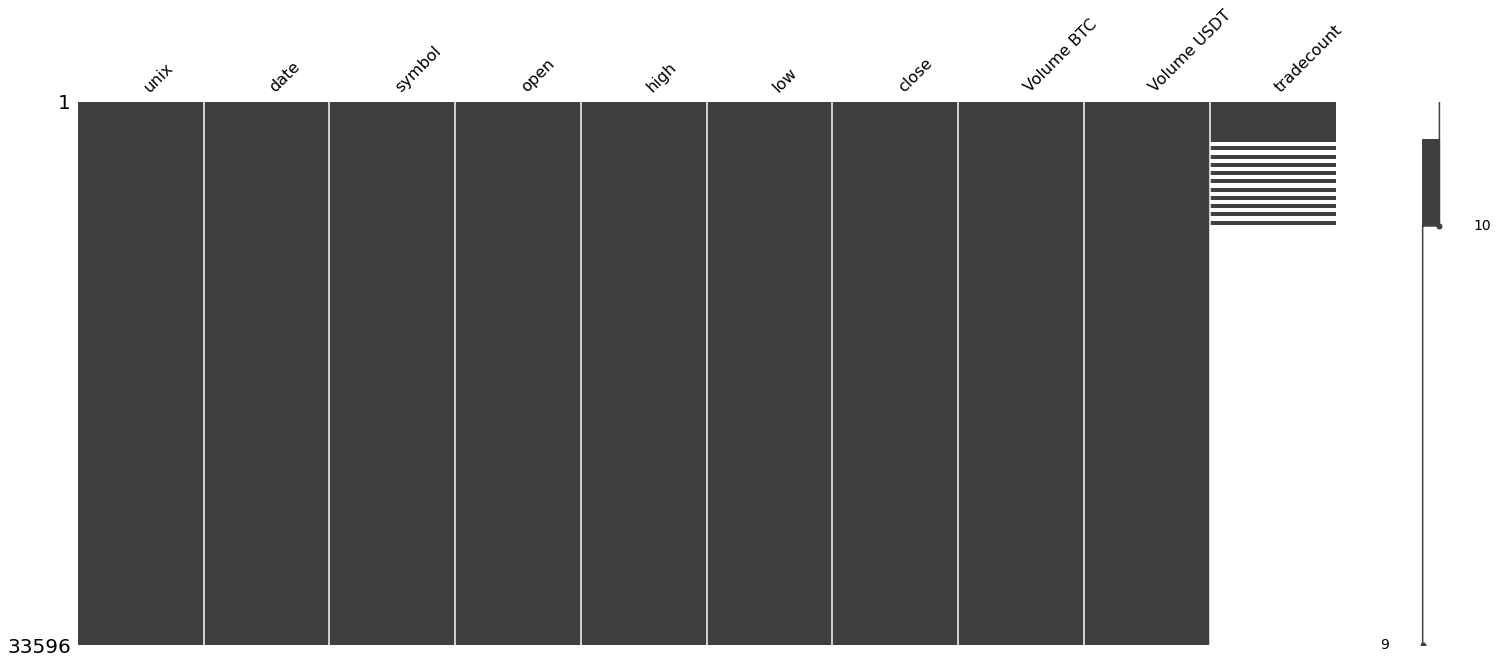

In [4]:
msno.matrix(dataframe)

In [5]:
dataframe.isnull().sum()

unix               0
date               0
symbol             0
open               0
high               0
low                0
close              0
Volume BTC         0
Volume USDT        0
tradecount     28584
dtype: int64

In [6]:
df_copy = dataframe.copy()
df_copy = df_copy.drop(columns=['tradecount'])

In [7]:
import datetime

def formatTime(time):
    time_len = len(str(time))
    if time_len == 12:
        return (datetime.datetime.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))
    else: 
        return (datetime.datetime.utcfromtimestamp(time/1000)).strftime('%Y-%m-%d %H:%M:%S')

In [8]:
%%time

df_copy['unix_num'] = dataframe['unix'].apply(lambda x: len(str(x)))
df_copy['time_str'] = dataframe['unix'].apply(lambda x: formatTime(x))
df_copy['time'] = pd.to_datetime(df_copy['time_str'].values)
df_copy['hour'] = df_copy['time'].apply(lambda x: x.hour)
df_copy['week_day'] = df_copy['time'].apply(lambda x: x.weekday())
df_copy.sort_values(by=['unix'], ascending=[True], inplace=True)

Wall time: 1.91 s


In [9]:
%%time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler(feature_range=(-1, 1))
X = df_copy[['hour', 'week_day', 'Volume BTC', 'close']]
y = df_copy[['close']]

scaler_X = scaler.fit(X)
scaler_y = scaler.fit(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_scal = scaler_X.transform(X_train)
X_test_scal = scaler_X.transform(X_test)
y_train_scal = scaler_y.transform(y_train)
y_test_scal = scaler_y.transform(y_test)

Wall time: 9.79 s


In [10]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (26876, 4)
X_test shape: (6720, 4)
y_train shape: (26876, 1)
y_test shape: (6720, 1)


In [11]:
def createDataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [12]:
%%time
time_steps = 24
X_train_f, y_train_f = createDataset(X_train_scal, y_train_scal, time_steps)
X_test_f, y_test_f = createDataset(X_test_scal, y_test_scal, time_steps)

print(f'X_train shape: {X_train_f.shape}')
print(f'X_test shape: {X_test_f.shape}')
print(f'y_train shape: {y_train_f.shape}')
print(f'y_test shape: {y_test_f.shape}')

X_train shape: (26852, 24, 4)
X_test shape: (6696, 24, 4)
y_train shape: (26852, 1)
y_test shape: (6696, 1)
Wall time: 97.8 ms


In [81]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.layers import BatchNormalization
import keras

model = Sequential()
model.add(keras.Input(shape=((X_train_f.shape[1], X_train_f.shape[2]))))
#model.add(Bidirectional(LSTM(300, activation='tanh', return_sequences=False)))
model.add(LSTM(300, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh', return_sequences=False))
model.add(BatchNormalization())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 300)               366000    
_________________________________________________________________
batch_normalization_6 (Batch (None, 300)               1200      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 301       
Total params: 367,501
Trainable params: 366,901
Non-trainable params: 600
_________________________________________________________________


In [83]:
history = model.fit(X_train_f, y_train_f, batch_size=256, epochs=30, shuffle=False, verbose=1)

Epoch 1/30
105/105 [==============================] - 2s 21ms/step - loss: 0.0029
Epoch 2/30
105/105 [==============================] - 2s 21ms/step - loss: 0.0029
Epoch 3/30
105/105 [==============================] - 2s 21ms/step - loss: 0.0029
Epoch 4/30
105/105 [==============================] - 2s 21ms/step - loss: 0.0029
Epoch 5/30
105/105 [==============================] - 2s 22ms/step - loss: 0.0029
Epoch 6/30
105/105 [==============================] - 2s 21ms/step - loss: 0.0029
Epoch 7/30
105/105 [==============================] - 2s 20ms/step - loss: 0.0029
Epoch 8/30
105/105 [==============================] - 2s 23ms/step - loss: 0.0029
Epoch 9/30
105/105 [==============================] - 2s 21ms/step - loss: 0.0029
Epoch 10/30
105/105 [==============================] - 3s 24ms/step - loss: 0.0029
Epoch 11/30
105/105 [==============================] - 2s 23ms/step - loss: 0.0030: 0s - loss
Epoch 12/30
105/105 [==============================] - 2s 22ms/step - loss: 0.0030
Ep

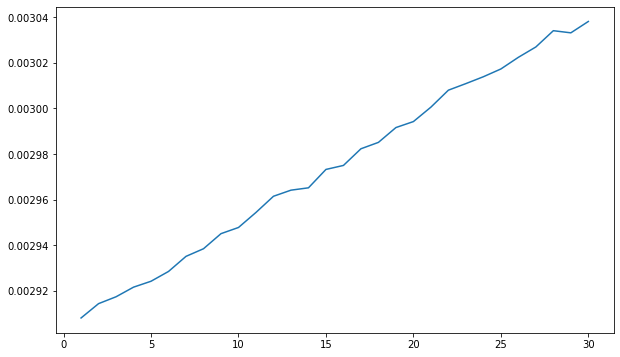

In [84]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(epochs, loss, label='Training loss')

In [85]:
import math

prediction = model.predict(X_test_f)
y_test_inv = scaler_y.inverse_transform(y_test_f)
prediction_inv = scaler_y.inverse_transform(prediction)
combined_array = np.concatenate((y_test_inv, prediction_inv), axis=1)
combined_array_2 = np.concatenate((X_test.iloc[time_steps:], combined_array), axis=1)

df_final = pd.DataFrame(data = combined_array, columns=["actual", "predicted"])
print("size: %d" % (len(combined_array)))
df_final.head()

size: 6696


,actual,predicted
0,10223.57,13466.158203
1,10284.47,13466.713867
2,10259.81,13523.367188
3,10260.75,13501.689453
4,10293.61,13503.748047


In [86]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

results = model.evaluate(X_test_f, y_test_f)
print("mse: %s" % (mean_squared_error(y_test_inv, prediction_inv)))
print(results)

210/210 [==============================] - 1s 4ms/step - loss: 0.0136
mse: 10374339.62960134
0.013587040826678276


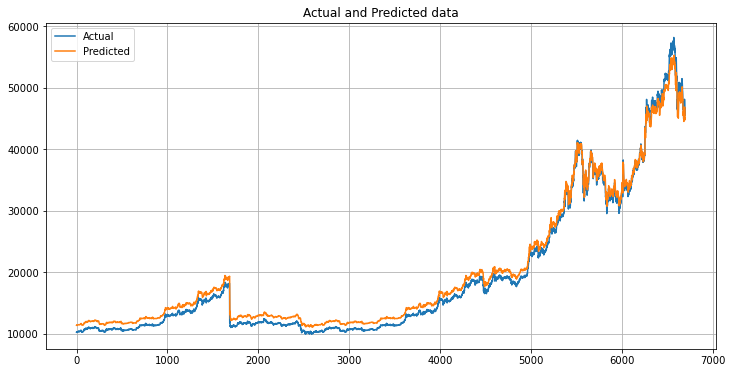

In [80]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(df_final['actual'], label='Actual')
ax.plot(df_final['predicted'], label='Predicted')
ax.set_title('Actual and Predicted data')
ax.legend()
ax.grid(True)

In [62]:
from keras.models import save_model
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from pickle import dump
from pickle import load

In [63]:
def buildModel(hyperparameters):
    model = Sequential()
    model.add(LSTM(hyperparameters.Int('input_unit', min_value=32, max_value=512, step=32), return_sequences=True, input_shape=(X_train_f.shape[1], X_train_f.shape[2])))
    for i in range(hyperparameters.Int('n_layers', 1, 3)):
        model.add(LSTM(hyperparameters.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32), return_sequences=True))
        model.add(Dropout(hyperparameters.Float('Dropout_rate', min_value=0, max_value=0.4, step=0.1)))
    model.add(LSTM(hyperparameters.Int('layer_2_neurons', min_value=32, max_value=512, step=32)))
    model.add(Dropout(hyperparameters.Float('Dropout_rate', min_value=0, max_value=0.4, step=0.1)))
    model.add(Dense(1, activation=hyperparameters.Choice('dense_activation', values=['relu', 'sigmoid', 'softmax'], default='relu')))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])
    return model

In [64]:
tuner = RandomSearch(buildModel, objective='mse', max_trials=2, executions_per_trial=1)
tuner.search(x=X_train_f, y=y_train_f, epochs=15, batch_size=64, validation_data=(X_test_f, y_test_f))

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [65]:
best_model = tuner.get_best_models(num_models=1)[0]

In [66]:
prediction = best_model.predict(X_test_f)

In [67]:
save_model(best_model, 'model.h5')

In [68]:
y_test_inv = scaler_y.inverse_transform(y_test_f)
prediction_inv = scaler_y.inverse_transform(prediction)
combined_array = np.concatenate((y_test_inv, prediction_inv), axis=1)
combined_array_2 = np.concatenate((X_test.iloc[time_steps:], combined_array), axis=1)

df_final = pd.DataFrame(data = combined_array, columns=["actual", "predicted"])
print("size: %d" % (len(combined_array)))
df_final.head()

size: 6696


,actual,predicted
0,2.825318e+08,30551.345703
1,2.842146e+08,30551.345703
2,2.835332e+08,30551.345703
3,2.835591e+08,30551.345703
4,2.844671e+08,30551.345703


In [72]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

results = best_model.evaluate(X_test_f, y_test_f)
print("mse: %s" % (mean_squared_error(y_test_inv, prediction_inv)))
print(results)

210/210 [==============================] - 2s 9ms/step - loss: 501704320.0000 - mse: 501704320.0000
mse: 3.8307457458614e+17
[501704320.0, 501704320.0]
